<a href="https://colab.research.google.com/github/MarielaNina/NeuralNetworksClass/blob/main/NN_MARIELA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projeto 1 - Rede Neural MLP

**Disciplina:** Redes Neurais  
**Professor:** Marcos G. Quiles  

---

## Objetivo

Implementar e avaliar redes **MLP (Perceptron MultiCamada)** para problemas de **classificação** e **regressão**, explorando:

- Diferentes **topologias** de rede
- Uso de **momentum**
- **Regularização L2**

---

## Datasets

1. **Classificação:** Wine Dataset (`sklearn.datasets.load_wine`)
2. **Regressão:** California Housing Dataset (`sklearn.datasets.fetch_california_housing`)

---

##  Algoritmo

Implementação **do zero** do **SGD (Stochastic Gradient Descent)** para treinar as redes MLP.


In [200]:
#importar bibliotecas
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_wine, fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, mean_squared_error, r2_score,
                             classification_report, confusion_matrix, mean_absolute_error)
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
# Configurar estilo dos gráficos
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")


   CLASSE MLP - Multi-Layer Perceptron


    Implementação de uma Rede Neural MLP com:
    - SGD (Stochastic Gradient Descent)
    - Momentum opcional
    - Regularização L2 opcional
    - Funções de ativação: ReLU e Sigmoid
    - Suporte para classificação e regressão


In [201]:

class MLP:

    def __init__(self, layers, learning_rate=0.01, momentum=0.0, l2_lambda=0.0,
                 activation='relu', task='classification'):
        """
        Inicializa a rede neural MLP

        Args:
            layers (list): Lista com número de neurônios [input, hidden..., output]
            learning_rate (float): Taxa de aprendizado para SGD
            momentum (float): Coeficiente de momentum (0 = sem momentum)
            l2_lambda (float): Coeficiente de regularização L2 (0 = sem L2)
            activation (str): 'relu' ou 'sigmoid' para camadas ocultas
            task (str): 'classification' ou 'regression'
        """
        self.layers = layers
        self.lr = learning_rate
        self.momentum = momentum
        self.l2_lambda = l2_lambda
        self.activation_name = activation
        self.task = task

        # Inicializar pesos e bias
        self.weights = []
        self.biases = []
        self.velocity_w = []  # Para momentum
        self.velocity_b = []  # Para momentum

        # Inicialização de pesos: He para ReLU, Xavier para Sigmoid
        for i in range(len(layers) - 1):
            if activation == 'relu':
                w = np.random.randn(layers[i], layers[i+1]) * np.sqrt(2.0 / layers[i])
            else:
                w = np.random.randn(layers[i], layers[i+1]) * np.sqrt(1.0 / layers[i])

            b = np.zeros((1, layers[i+1]))

            self.weights.append(w)
            self.biases.append(b)
            self.velocity_w.append(np.zeros_like(w))
            self.velocity_b.append(np.zeros_like(b))

        # Histórico de treinamento
        self.train_losses = []
        self.val_losses = []
        self.train_accs = []
        self.val_accs = []

    def relu(self, z):
        """Função de ativação ReLU"""
        return np.maximum(0, z)

    def relu_derivative(self, z):
        """Derivada da ReLU"""
        return (z > 0).astype(float)

    def sigmoid(self, z):
        """Função de ativação Sigmoid"""
        return 1 / (1 + np.exp(-np.clip(z, -500, 500)))

    def sigmoid_derivative(self, z):
        """Derivada da Sigmoid"""
        s = self.sigmoid(z)
        return s * (1 - s)

    def softmax(self, z):
        """Função Softmax para classificação multiclasse"""
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def activate(self, z):
        """Aplica função de ativação"""
        if self.activation_name == 'relu':
            return self.relu(z)
        else:
            return self.sigmoid(z)

    def activate_derivative(self, z):
        """Derivada da função de ativação"""
        if self.activation_name == 'relu':
            return self.relu_derivative(z)
        else:
            return self.sigmoid_derivative(z)

    def forward(self, X):
        """
        Propagação para frente (Forward Pass)
        Calcula a saída da rede para uma entrada X
        """
        self.activations = [X]
        self.z_values = []

        for i in range(len(self.weights)):
            z = np.dot(self.activations[-1], self.weights[i]) + self.biases[i]
            self.z_values.append(z)

            # Última camada
            if i == len(self.weights) - 1:
                if self.task == 'classification':
                    a = self.softmax(z)  # Softmax para classificação
                else:
                    a = z  # Ativação linear para regressão
            else:
                a = self.activate(z)  # ReLU ou Sigmoid

            self.activations.append(a)

        return self.activations[-1]

    def compute_loss(self, y_true, y_pred):
        """
        Calcula a função de custo
        - Cross-Entropy para classificação
        - MSE para regressão
        + Regularização L2 (se aplicável)
        """
        m = y_true.shape[0]

        if self.task == 'classification':
            # Cross-entropy loss
            loss = -np.sum(y_true * np.log(y_pred + 1e-8)) / m
        else:
            # MSE loss
            loss = np.mean((y_true - y_pred) ** 2)

        # Adicionar regularização L2
        if self.l2_lambda > 0:
            l2_penalty = 0
            for w in self.weights:
                l2_penalty += np.sum(w ** 2)
            loss += (self.l2_lambda / (2 * m)) * l2_penalty

        return loss

    def backward(self, X, y):
        """
        Propagação para trás (Backpropagation)
        Calcula os gradientes da função de custo em relação aos pesos
        """
        m = X.shape[0]
        gradients_w = []
        gradients_b = []

        # Erro da camada de saída
        delta = self.activations[-1] - y

        # Backpropagation através das camadas
        for i in range(len(self.weights) - 1, -1, -1):
            # Calcular gradientes
            grad_w = np.dot(self.activations[i].T, delta) / m
            grad_b = np.sum(delta, axis=0, keepdims=True) / m

            # Adicionar regularização L2
            if self.l2_lambda > 0:
                grad_w += (self.l2_lambda / m) * self.weights[i]

            gradients_w.insert(0, grad_w)
            gradients_b.insert(0, grad_b)

            # Propagar erro para camada anterior
            if i > 0:
                delta = np.dot(delta, self.weights[i].T) * self.activate_derivative(self.z_values[i-1])

        return gradients_w, gradients_b

    def update_weights(self, gradients_w, gradients_b):
        """
        Atualização dos pesos usando SGD com Momentum

        Fórmula com Momentum:
        v(t) = momentum * v(t-1) - lr * gradient
        w(t) = w(t-1) + v(t)
        """
        for i in range(len(self.weights)):
            # Calcular velocidade com momentum
            self.velocity_w[i] = self.momentum * self.velocity_w[i] - self.lr * gradients_w[i]
            self.velocity_b[i] = self.momentum * self.velocity_b[i] - self.lr * gradients_b[i]

            # Atualizar pesos
            self.weights[i] += self.velocity_w[i]
            self.biases[i] += self.velocity_b[i]

    def train(self, X_train, y_train, X_val, y_val, epochs=100, batch_size=32, verbose=True):
        """
        Treina a rede neural usando Mini-Batch SGD

        Args:
            X_train, y_train: Dados de treinamento
            X_val, y_val: Dados de validação
            epochs: Número de épocas
            batch_size: Tamanho do mini-batch
            verbose: Se True, imprime progresso
        """
        n_samples = X_train.shape[0]

        for epoch in range(epochs):
            # Embaralhar dados a cada época
            indices = np.random.permutation(n_samples)
            X_shuffled = X_train[indices]
            y_shuffled = y_train[indices]

            # Mini-batch SGD
            for i in range(0, n_samples, batch_size):
                X_batch = X_shuffled[i:i+batch_size]
                y_batch = y_shuffled[i:i+batch_size]

                # Forward pass
                self.forward(X_batch)

                # Backward pass
                gradients_w, gradients_b = self.backward(X_batch, y_batch)

                # Update weights
                self.update_weights(gradients_w, gradients_b)

            # Calcular métricas de treino e validação
            train_pred = self.forward(X_train)
            val_pred = self.forward(X_val)

            train_loss = self.compute_loss(y_train, train_pred)
            val_loss = self.compute_loss(y_val, val_pred)

            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)

            if self.task == 'classification':
                train_acc = accuracy_score(np.argmax(y_train, axis=1), np.argmax(train_pred, axis=1))
                val_acc = accuracy_score(np.argmax(y_val, axis=1), np.argmax(val_pred, axis=1))
                self.train_accs.append(train_acc)
                self.val_accs.append(val_acc)

                if verbose and (epoch + 1) % 20 == 0:
                    print(f"  Época {epoch+1:3d}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
                          f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")
            else:
                if verbose and (epoch + 1) % 20 == 0:
                    print(f"  Época {epoch+1:3d}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    def predict(self, X):
        """Predições para novos dados"""
        output = self.forward(X)
        if self.task == 'classification':
            return np.argmax(output, axis=1)
        else:
            return output.flatten()

FUNÇÕES AUXILIARES PARA PREPARAÇÃO DOS DADOS

In [202]:
def prepare_classification_data():
    """
    Dataset: Wine Recognition Database
    - 178 amostras
    - 13 características (químicas do vinho)
    - 3 classes (tipos de vinho)

    Divisão: 60% treino / 20% validação / 20% teste
    """

    print("DATASET DE CLASSIFICAÇÃO - Wine Dataset")
    print("="*100)

    wine = load_wine()
    X, y = wine.data, wine.target

    print(f"\n- Total de amostras: {X.shape[0]}")
    print(f"- Número de features: {X.shape[1]}")
    print(f"- Número de classes: {len(np.unique(y))}")
    print(f"- Distribuição de classes: {np.bincount(y)}")

    # Split: 60% treino, 20% validação, 20% teste
    X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

    print(f"\n- Treino: {X_train.shape[0]} amostras")
    print(f"- Validação: {X_val.shape[0]} amostras")
    print(f"- Teste: {X_test.shape[0]} amostras")

    # Normalizar features (StandardScaler)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)Faz p
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    print("- Features normalizadas (μ=0, σ=1)")

    # One-hot encoding para labels
    n_classes = len(np.unique(y))
    y_train_oh = np.eye(n_classes)[y_train]
    y_val_oh = np.eye(n_classes)[y_val]
    y_test_oh = np.eye(n_classes)[y_test]

    return (X_train, y_train_oh, y_train), (X_val, y_val_oh, y_val), (X_test, y_test_oh, y_test), wine.target_names

In [203]:
def prepare_regression_data():
    """
    Dataset de REGRESSÃO (California Housing)

    Dataset: California Housing Prices
    - 20640 amostras (usando subset de 5000 para acelerar)
    - 8 características (localização, estrutura da casa, etc.)
    - Target: Preço médio da casa (em $100,000)

    Divisão: 60% treino / 20% validação / 20% teste
    """

    print("DATASET DE REGRESSÃO - California Housing")
    print("="*100)

    housing = fetch_california_housing()
    X, y = housing.data, housing.target

    # Usar subset para acelerar treinamento
    X = X[:5000]
    y = y[:5000]

    print(f"\n Total de amostras: {X.shape[0]}")
    print(f" Número de features: {X.shape[1]}")
    print(f" Target: Preço médio da casa")
    print(f" Range do target: ${y.min():.2f} - ${y.max():.2f} (x100k)")

    # Split: 60% treino, 20% validação, 20% teste
    X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

    print(f"\n Treino: {X_train.shape[0]} amostras")
    print(f" Validação: {X_val.shape[0]} amostras")
    print(f" Teste: {X_test.shape[0]} amostras")

    # Normalizar features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    print(" Features normalizadas (μ=0, σ=1)")

    return (X_train, y_train.reshape(-1, 1)), (X_val, y_val.reshape(-1, 1)), (X_test, y_test.reshape(-1, 1))

 FUNÇÕES DE VISUALIZAÇÃO E ANÁLISE

In [204]:
def plot_training_history(models_results, task='classification', save_name='training'):
    """
    Plota a evolução do treinamento (Loss e Acurácia)
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))

    colors = plt.cm.tab10(np.linspace(0, 1, len(models_results)))

    # Plot 1: Loss (Treino e Validação)
    for idx, result in enumerate(models_results):
        axes[0].plot(result['train_losses'], label=f"{result['name']} (Train)",
                    alpha=0.7, linewidth=2, color=colors[idx])
        axes[0].plot(result['val_losses'], label=f"{result['name']} (Val)",
                    linestyle='--', alpha=0.7, linewidth=2, color=colors[idx])

    axes[0].set_xlabel('Época', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Loss', fontsize=12, fontweight='bold')
    axes[0].set_title('Evolução da Função de Custo', fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=9, loc='best')
    axes[0].grid(True, alpha=0.3)

    # Plot 2: Acurácia (apenas para classificação)
    if task == 'classification':
        for idx, result in enumerate(models_results):
            axes[1].plot(result['train_accs'], label=f"{result['name']} (Train)",
                        alpha=0.7, linewidth=2, color=colors[idx])
            axes[1].plot(result['val_accs'], label=f"{result['name']} (Val)",
                        linestyle='--', alpha=0.7, linewidth=2, color=colors[idx])

        axes[1].set_xlabel('Época', fontsize=12, fontweight='bold')
        axes[1].set_ylabel('Acurácia', fontsize=12, fontweight='bold')
        axes[1].set_title('Evolução da Acurácia', fontsize=14, fontweight='bold')
        axes[1].legend(fontsize=9, loc='best')
        axes[1].grid(True, alpha=0.3)
    else:
        axes[1].axis('off')

    plt.tight_layout()
    plt.show()

In [205]:
def plot_confusion_matrix(y_true, y_pred, class_names, title="Matriz de Confusão", save_name='confusion'):
    """
    Plota a matriz de confusão
    """
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Contagem'})
    plt.title(title, fontsize=14, fontweight='bold')
    plt.ylabel('Classe Verdadeira', fontsize=12, fontweight='bold')
    plt.xlabel('Classe Predita', fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()


In [206]:

def plot_test_predictions(y_true, y_pred, title="Predições vs Real", save_name='predictions'):
    """
    Plota predições vs valores reais (para regressão)
    """
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.5, s=30)

    # Linha de predição perfeita
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Predição Perfeita')

    plt.xlabel('Valor Real', fontsize=12, fontweight='bold')
    plt.ylabel('Valor Predito', fontsize=12, fontweight='bold')
    plt.title(title, fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


In [207]:

def create_results_table(results, task='classification'):
    """
    Tabela com os resultados
    """
    if task == 'classification':
        data = {
            'Topologia': [r['name'] for r in results],
            'Acurácia Teste': [f"{r['test_acc']:.4f}" for r in results],
            'Loss Final (Train)': [f"{r['train_losses'][-1]:.4f}" for r in results],
            'Loss Final (Val)': [f"{r['val_losses'][-1]:.4f}" for r in results],
        }
    else:
        data = {
            'Topologia': [r['name'] for r in results],
            'MSE Teste': [f"{r['test_mse']:.4f}" for r in results],
            'R² Score': [f"{r['test_r2']:.4f}" for r in results],
            'Loss Final (Train)': [f"{r['train_losses'][-1]:.4f}" for r in results],
            'Loss Final (Val)': [f"{r['val_losses'][-1]:.4f}" for r in results],
        }

    df = pd.DataFrame(data)
    return df



EXPERIMENTOS DE CLASSIFICAÇÃO

In [208]:
def run_classification_experiments():
    # Preparar dados
    (X_train, y_train_oh, y_train), (X_val, y_val_oh, y_val), (X_test, y_test_oh, y_test), class_names = prepare_classification_data()

    input_size = X_train.shape[1]
    output_size = y_train_oh.shape[1]


    # EXPERIMENTO 1: DIFERENTES TOPOLOGIAS

    print("\n" + "="*100)
    print(" EXPERIMENTO 1: Avaliando Diferentes Topologias")
    print("="*100)
    print("\nObjetivo: Comparar o desempenho de 5 arquiteturas diferentes")
    print("Configuração: SGD puro (sem momentum, sem L2)\n")

    topologies = [
        ([input_size, 32, output_size], "1 camada: [32]"),
        ([input_size, 64, output_size], "1 camada: [64]"),
        ([input_size, 32, 16, output_size], "2 camadas: [32, 16]"),
        ([input_size, 64, 32, output_size], "2 camadas: [64, 32]"),
        ([input_size, 64, 32, 16, output_size], "3 camadas: [64, 32, 16]"),
    ]

    results_topologies = []

    for topology, name in topologies:
        print(f"\n ° Treinando: {name}")
        print(f"   Arquitetura: {topology}")

        model = MLP(topology, learning_rate=0.01, momentum=0.0, l2_lambda=0.0,
                   activation='relu', task='classification')
        model.train(X_train, y_train_oh, X_val, y_val_oh, epochs=100, batch_size=32, verbose=True)

        # Avaliar no conjunto de teste
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)

        print(f"\n    Acurácia no Teste: {acc:.4f}")

        results_topologies.append({
            'name': name,
            'train_losses': model.train_losses,
            'val_losses': model.val_losses,
            'train_accs': model.train_accs,
            'val_accs': model.val_accs,
            'test_acc': acc,
            'y_pred': y_pred
        })

    # Plotar evolução do treinamento
    print("\n Evolução do treinamento.")
    plot_training_history(results_topologies, task='classification', save_name='classification_topologies')

    # Criar tabela de resultados
    print("\n TABELA DE RESULTADOS - DIFERENTES TOPOLOGIAS")
    print("="*100)
    df_topologies = create_results_table(results_topologies, task='classification')
    print(df_topologies.to_string(index=False))

    # Matriz de confusão para melhor modelo
    best_idx = np.argmax([r['test_acc'] for r in results_topologies])
    best_model_result = results_topologies[best_idx]

    print(f"\n Melhor Topologia: {best_model_result['name']}")
    print(f"   Acurácia: {best_model_result['test_acc']:.4f}")

    print("\n Matriz de confusão.")
    plot_confusion_matrix(y_test, best_model_result['y_pred'], class_names,
                         title=f"Matriz de Confusão - {best_model_result['name']}",
                         save_name='classification_best')


    # EXPERIMENTO 2: IMPACTO DO MOMENTUM

    print("\n" + "="*100)
    print("EXPERIMENTO 2: Avaliando o Impacto do Momentum")
    print("="*100)
    print("\nObjetivo: Avaliar como o momentum afeta a convergência")
    print("Topologia fixa: [64, 32]\n")

    base_topology = [input_size, 64, 32, output_size]
    momentum_values = [0.0, 0.5, 0.9]
    results_momentum = []

    for momentum in momentum_values:
        print(f"\n ° Treinando com Momentum = {momentum}")

        model = MLP(base_topology, learning_rate=0.01, momentum=momentum, l2_lambda=0.0,
                   activation='relu', task='classification')
        model.train(X_train, y_train_oh, X_val, y_val_oh, epochs=100, batch_size=32, verbose=True)

        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)

        print(f"\n    Acurácia no Teste: {acc:.4f}")

        results_momentum.append({
            'name': f"Momentum={momentum}",
            'train_losses': model.train_losses,
            'val_losses': model.val_losses,
            'train_accs': model.train_accs,
            'val_accs': model.val_accs,
            'test_acc': acc,
            'momentum': momentum
        })

    print("\n Comparação do momentum.")
    plot_training_history(results_momentum, task='classification', save_name='classification_momentum')

    print("\n TABELA DE RESULTADOS - IMPACTO DO MOMENTUM")
    print("="*100)
    df_momentum = create_results_table(results_momentum, task='classification')
    print(df_momentum.to_string(index=False))


    # EXPERIMENTO 3: IMPACTO DA REGULARIZAÇÃO L2

    print("\n" + "="*100)
    print("EXPERIMENTO 3: Avaliando o Impacto da Regularização L2")
    print("="*100)
    print("\nObjetivo: Avaliar como a regularização L2 previne overfitting")
    print("Topologia fixa: [64, 32]\n")

    l2_values = [0.0, 0.001, 0.01, 0.1]
    results_l2 = []

    for l2_lambda in l2_values:
        print(f"\n ° Treinando com L2 Lambda = {l2_lambda}")

        model = MLP(base_topology, learning_rate=0.01, momentum=0.0, l2_lambda=l2_lambda,
                   activation='relu', task='classification')
        model.train(X_train, y_train_oh, X_val, y_val_oh, epochs=100, batch_size=32, verbose=True)

        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)

        print(f"\n Acurácia no Teste: {acc:.4f}")

        results_l2.append({
            'name': f"L2={l2_lambda}",
            'train_losses': model.train_losses,
            'val_losses': model.val_losses,
            'train_accs': model.train_accs,
            'val_accs': model.val_accs,
            'test_acc': acc,
            'l2_lambda': l2_lambda
        })

    print("\n Comparação da regularização L2.")
    plot_training_history(results_l2, task='classification', save_name='classification_l2')

    print("\n TABELA DE RESULTADOS - IMPACTO DA REGULARIZAÇÃO L2")
    print("="*100)
    df_l2 = create_results_table(results_l2, task='classification')
    print(df_l2.to_string(index=False))


    # RELATÓRIO FINAL - CLASSIFICAÇÃO

    print("\n" + "="*100)
    print(" RELATÓRIO FINAL - CLASSIFICAÇÃO")
    print("="*100)

    print("\n RESUMO DOS EXPERIMENTOS:")
    print("\n 1.TOPOLOGIAS TESTADAS:")
    for i, result in enumerate(results_topologies, 1):
        print(f"   {i}. {result['name']}: Acurácia = {result['test_acc']:.4f}")

    print("\n 2.IMPACTO DO MOMENTUM:")
    for result in results_momentum:
        print(f"   • {result['name']}: Acurácia = {result['test_acc']:.4f}")

    print("\n 3.IMPACTO DA REGULARIZAÇÃO L2:")
    for result in results_l2:
        print(f"   • {result['name']}: Acurácia = {result['test_acc']:.4f}")

    # Relatório detalhado do melhor modelo
    print("\n" + "="*100)
    print(" MELHOR MODELO GERAL")
    print("="*100)

    all_results = results_topologies + results_momentum + results_l2
    best_overall = max(all_results, key=lambda x: x['test_acc'])

    print(f"\nConfiguração: {best_overall['name']}")
    print(f"Acurácia no Teste: {best_overall['test_acc']:.4f}")
    print(f"Loss Final (Treino): {best_overall['train_losses'][-1]:.4f}")
    print(f"Loss Final (Validação): {best_overall['val_losses'][-1]:.4f}")

    return results_topologies, results_momentum, results_l2

DATASET DE CLASSIFICAÇÃO - Wine Dataset

- Total de amostras: 178
- Número de features: 13
- Número de classes: 3
- Distribuição de classes: [59 71 48]

- Treino: 106 amostras
- Validação: 36 amostras
- Teste: 36 amostras
- Features normalizadas (μ=0, σ=1)

 EXPERIMENTO 1: Avaliando Diferentes Topologias

Objetivo: Comparar o desempenho de 5 arquiteturas diferentes
Configuração: SGD puro (sem momentum, sem L2)


 ° Treinando: 1 camada: [32]
   Arquitetura: [13, 32, 3]
  Época  20/100 | Train Loss: 0.2947 | Val Loss: 0.3287 | Train Acc: 0.9434 | Val Acc: 0.9444
  Época  40/100 | Train Loss: 0.1795 | Val Loss: 0.2134 | Train Acc: 0.9717 | Val Acc: 0.9722
  Época  60/100 | Train Loss: 0.1319 | Val Loss: 0.1594 | Train Acc: 0.9717 | Val Acc: 1.0000
  Época  80/100 | Train Loss: 0.1054 | Val Loss: 0.1283 | Train Acc: 0.9811 | Val Acc: 1.0000
  Época 100/100 | Train Loss: 0.0883 | Val Loss: 0.1091 | Train Acc: 1.0000 | Val Acc: 1.0000

    Acurácia no Teste: 0.9722

 ° Treinando: 1 camada: [

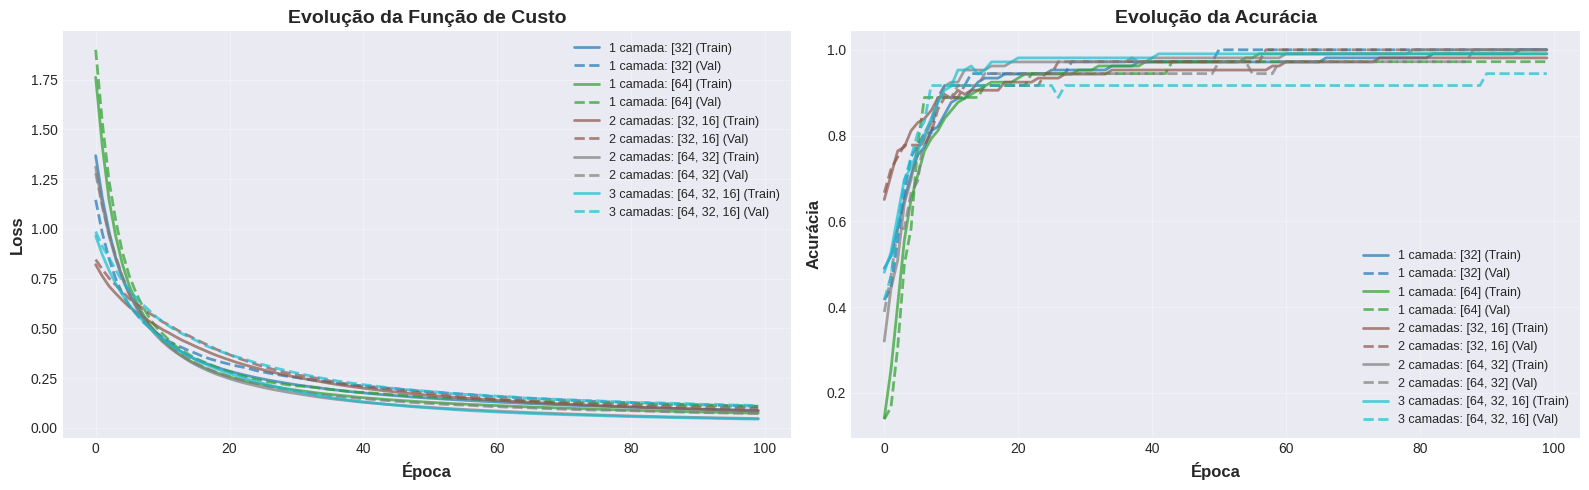


 TABELA DE RESULTADOS - DIFERENTES TOPOLOGIAS
              Topologia Acurácia Teste Loss Final (Train) Loss Final (Val)
         1 camada: [32]         0.9722             0.0883           0.1091
         1 camada: [64]         0.9722             0.0742           0.1074
    2 camadas: [32, 16]         1.0000             0.0849           0.0970
    2 camadas: [64, 32]         1.0000             0.0470           0.0723
3 camadas: [64, 32, 16]         0.9167             0.0444           0.1125

 Melhor Topologia: 2 camadas: [32, 16]
   Acurácia: 1.0000

 Matriz de confusão.


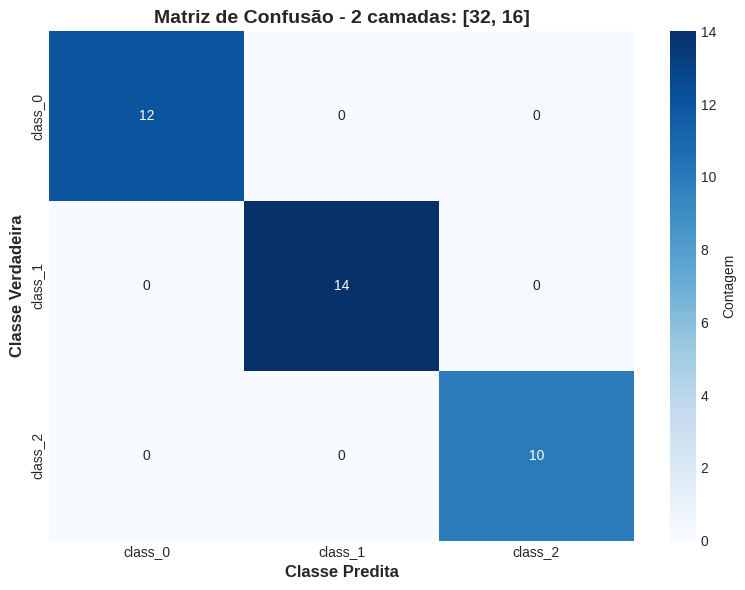


EXPERIMENTO 2: Avaliando o Impacto do Momentum

Objetivo: Avaliar como o momentum afeta a convergência
Topologia fixa: [64, 32]


 ° Treinando com Momentum = 0.0
  Época  20/100 | Train Loss: 0.1765 | Val Loss: 0.3103 | Train Acc: 0.9906 | Val Acc: 0.8889
  Época  40/100 | Train Loss: 0.0984 | Val Loss: 0.2607 | Train Acc: 1.0000 | Val Acc: 0.8889
  Época  60/100 | Train Loss: 0.0679 | Val Loss: 0.2427 | Train Acc: 1.0000 | Val Acc: 0.8889
  Época  80/100 | Train Loss: 0.0510 | Val Loss: 0.2335 | Train Acc: 1.0000 | Val Acc: 0.9167
  Época 100/100 | Train Loss: 0.0409 | Val Loss: 0.2282 | Train Acc: 1.0000 | Val Acc: 0.9167

    Acurácia no Teste: 0.9722

 ° Treinando com Momentum = 0.5
  Época  20/100 | Train Loss: 0.1393 | Val Loss: 0.1272 | Train Acc: 0.9717 | Val Acc: 0.9722
  Época  40/100 | Train Loss: 0.0638 | Val Loss: 0.0700 | Train Acc: 0.9906 | Val Acc: 1.0000
  Época  60/100 | Train Loss: 0.0381 | Val Loss: 0.0496 | Train Acc: 1.0000 | Val Acc: 1.0000
  Época  80/100 | Tra

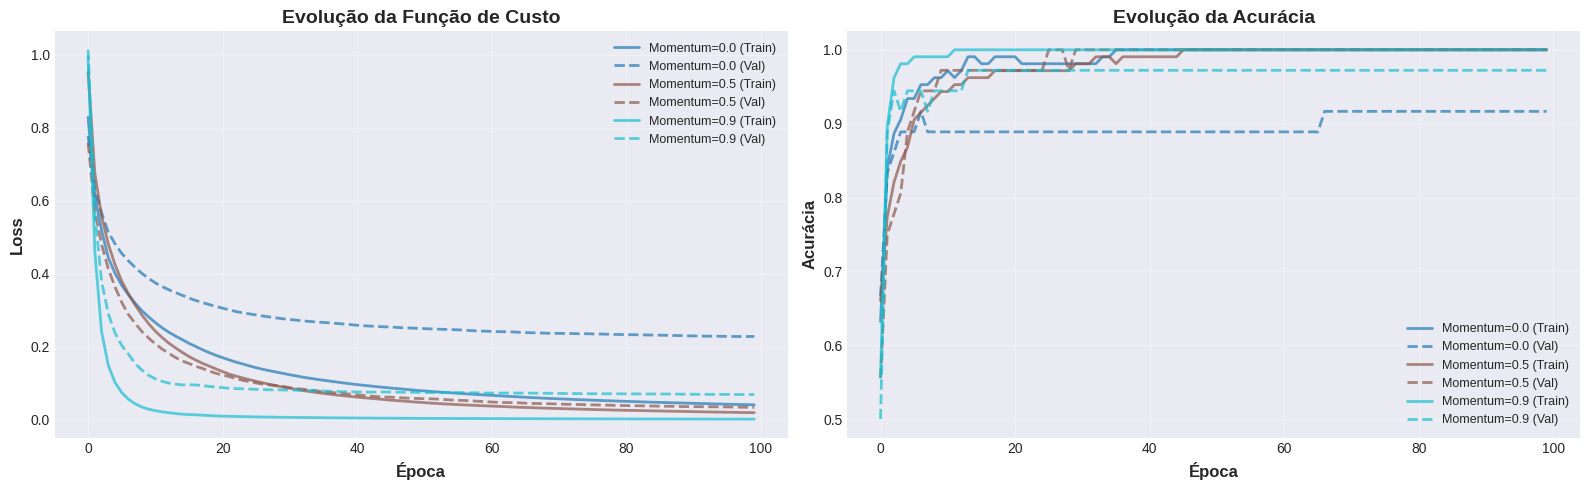


 TABELA DE RESULTADOS - IMPACTO DO MOMENTUM
   Topologia Acurácia Teste Loss Final (Train) Loss Final (Val)
Momentum=0.0         0.9722             0.0409           0.2282
Momentum=0.5         0.9444             0.0194           0.0340
Momentum=0.9         0.9722             0.0018           0.0689

EXPERIMENTO 3: Avaliando o Impacto da Regularização L2

Objetivo: Avaliar como a regularização L2 previne overfitting
Topologia fixa: [64, 32]


 ° Treinando com L2 Lambda = 0.0
  Época  20/100 | Train Loss: 0.1616 | Val Loss: 0.2224 | Train Acc: 0.9811 | Val Acc: 0.9444
  Época  40/100 | Train Loss: 0.0916 | Val Loss: 0.1331 | Train Acc: 0.9906 | Val Acc: 1.0000
  Época  60/100 | Train Loss: 0.0650 | Val Loss: 0.1027 | Train Acc: 0.9906 | Val Acc: 1.0000
  Época  80/100 | Train Loss: 0.0503 | Val Loss: 0.0872 | Train Acc: 0.9906 | Val Acc: 1.0000
  Época 100/100 | Train Loss: 0.0407 | Val Loss: 0.0745 | Train Acc: 0.9906 | Val Acc: 1.0000

 Acurácia no Teste: 0.9444

 ° Treinando com L2 L

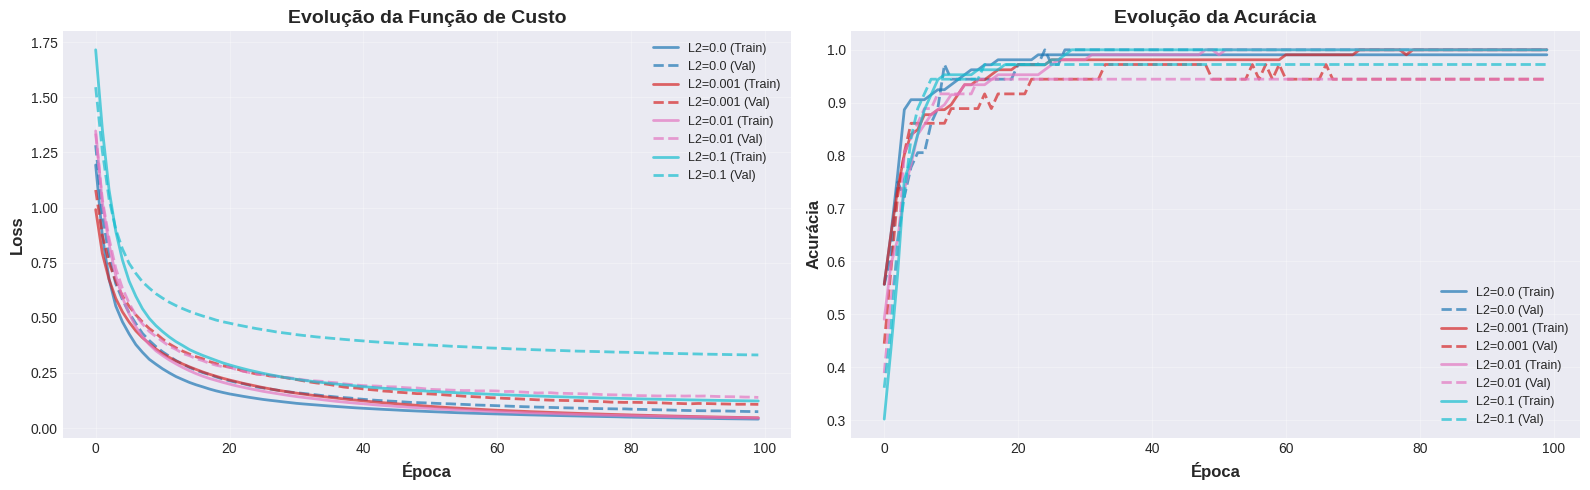


 TABELA DE RESULTADOS - IMPACTO DA REGULARIZAÇÃO L2
Topologia Acurácia Teste Loss Final (Train) Loss Final (Val)
   L2=0.0         0.9444             0.0407           0.0745
 L2=0.001         0.9722             0.0469           0.1076
  L2=0.01         0.9722             0.0454           0.1390
   L2=0.1         0.9722             0.1229           0.3316

 RELATÓRIO FINAL - CLASSIFICAÇÃO

 RESUMO DOS EXPERIMENTOS:

 1.TOPOLOGIAS TESTADAS:
   1. 1 camada: [32]: Acurácia = 0.9722
   2. 1 camada: [64]: Acurácia = 0.9722
   3. 2 camadas: [32, 16]: Acurácia = 1.0000
   4. 2 camadas: [64, 32]: Acurácia = 1.0000
   5. 3 camadas: [64, 32, 16]: Acurácia = 0.9167

 2.IMPACTO DO MOMENTUM:
   • Momentum=0.0: Acurácia = 0.9722
   • Momentum=0.5: Acurácia = 0.9444
   • Momentum=0.9: Acurácia = 0.9722

 3.IMPACTO DA REGULARIZAÇÃO L2:
   • L2=0.0: Acurácia = 0.9444
   • L2=0.001: Acurácia = 0.9722
   • L2=0.01: Acurácia = 0.9722
   • L2=0.1: Acurácia = 0.9722

 MELHOR MODELO GERAL

Configuração: 2 ca

In [209]:
# Experimentos de classificação
class_results = run_classification_experiments()

EXPERIMENTOS DE REGRESSÃO

In [210]:

def run_regression_experiments():

    # Preparar dados
    (X_train, y_train), (X_val, y_val), (X_test, y_test) = prepare_regression_data()

    input_size = X_train.shape[1]
    output_size = 1


    # EXPERIMENTO 1: DIFERENTES TOPOLOGIAS

    print("\n" + "="*100)
    print("EXPERIMENTO 1: Avaliando Diferentes Topologias")
    print("="*100)
    print("\nObjetivo: Comparar o desempenho de 5 arquiteturas diferentes")
    print("Configuração: SGD puro (sem momentum, sem L2)\n")

    topologies = [
        ([input_size, 32, output_size], "1 camada: [32]"),
        ([input_size, 64, output_size], "1 camada: [64]"),
        ([input_size, 32, 16, output_size], "2 camadas: [32, 16]"),
        ([input_size, 64, 32, output_size], "2 camadas: [64, 32]"),
        ([input_size, 64, 32, 16, output_size], "3 camadas: [64, 32, 16]"),
    ]

    results_topologies = []

    for topology, name in topologies:
        print(f"\n ° Treinando: {name}")
        print(f"Arquitetura: {topology}")

        model = MLP(topology, learning_rate=0.001, momentum=0.0, l2_lambda=0.0,
                   activation='relu', task='regression')
        model.train(X_train, y_train, X_val, y_val, epochs=100, batch_size=32, verbose=True)

        # Avaliar no conjunto de teste
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        print(f"\n   MSE no Teste: {mse:.4f}")
        print(f"   MAE no Teste: {mae:.4f}")
        print(f"   R² Score: {r2:.4f}")

        results_topologies.append({
            'name': name,
            'train_losses': model.train_losses,
            'val_losses': model.val_losses,
            'test_mse': mse,
            'test_mae': mae,
            'test_r2': r2,
            'y_pred': y_pred,
            'y_test': y_test
        })

    # Plotar evolução do treinamento
    print("\n Evolução do treinamento.")
    plot_training_history(results_topologies, task='regression', save_name='regression_topologies')

    # Criar tabela de resultados
    print("\n TABELA DE RESULTADOS - DIFERENTES TOPOLOGIAS")
    print("="*100)
    df_topologies = pd.DataFrame({
        'Topologia': [r['name'] for r in results_topologies],
        'MSE Teste': [f"{r['test_mse']:.4f}" for r in results_topologies],
        'MAE Teste': [f"{r['test_mae']:.4f}" for r in results_topologies],
        'R² Score': [f"{r['test_r2']:.4f}" for r in results_topologies],
        'Loss Final (Train)': [f"{r['train_losses'][-1]:.4f}" for r in results_topologies],
        'Loss Final (Val)': [f"{r['val_losses'][-1]:.4f}" for r in results_topologies],
    })
    print(df_topologies.to_string(index=False))

    # Gráfico de predições vs real para melhor modelo
    best_idx = np.argmax([r['test_r2'] for r in results_topologies])
    best_model_result = results_topologies[best_idx]

    print(f"\n Melhor Topologia: {best_model_result['name']}")
    print(f"   R² Score: {best_model_result['test_r2']:.4f}")

    print("\n Gráfico de predições.")
    plot_test_predictions(best_model_result['y_test'], best_model_result['y_pred'],
                         title=f"Predições vs Real - {best_model_result['name']}",
                         save_name='regression_best')


    # EXPERIMENTO 2: IMPACTO DO MOMENTUM

    print("\n" + "="*100)
    print("EXPERIMENTO 2: Avaliando o Impacto do Momentum")
    print("="*100)
    print("\nObjetivo: Avaliar como o momentum afeta a convergência")
    print("Topologia fixa: [64, 32]\n")

    base_topology = [input_size, 64, 32, output_size]
    momentum_values = [0.0, 0.5, 0.9]
    results_momentum = []

    for momentum in momentum_values:
        print(f"\n ° Treinando com Momentum = {momentum}")

        model = MLP(base_topology, learning_rate=0.001, momentum=momentum, l2_lambda=0.0,
                   activation='relu', task='regression')
        model.train(X_train, y_train, X_val, y_val, epochs=100, batch_size=32, verbose=True)

        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        print(f"\n   MSE no Teste: {mse:.4f}")
        print(f"   MAE no Teste: {mae:.4f}")
        print(f"   R² Score: {r2:.4f}")

        results_momentum.append({
            'name': f"Momentum={momentum}",
            'train_losses': model.train_losses,
            'val_losses': model.val_losses,
            'test_mse': mse,
            'test_mae': mae,
            'test_r2': r2,
            'momentum': momentum
        })

    print("\nComparação do momentum.")
    plot_training_history(results_momentum, task='regression', save_name='regression_momentum')

    print("\n TABELA DE RESULTADOS - IMPACTO DO MOMENTUM")
    print("="*100)
    df_momentum = pd.DataFrame({
        'Configuração': [r['name'] for r in results_momentum],
        'MSE Teste': [f"{r['test_mse']:.4f}" for r in results_momentum],
        'MAE Teste': [f"{r['test_mae']:.4f}" for r in results_momentum],
        'R² Score': [f"{r['test_r2']:.4f}" for r in results_momentum],
    })
    print(df_momentum.to_string(index=False))


    # EXPERIMENTO 3: IMPACTO DA REGULARIZAÇÃO L2

    print("\n" + "="*100)
    print("EXPERIMENTO 3: Avaliando o Impacto da Regularização L2")
    print("="*100)
    print("\nObjetivo: Avaliar como a regularização L2 previne overfitting")
    print("Topologia fixa: [64, 32]\n")

    l2_values = [0.0, 0.001, 0.01, 0.1]
    results_l2 = []

    for l2_lambda in l2_values:
        print(f"\n ° Treinando com L2 Lambda = {l2_lambda}")

        model = MLP(base_topology, learning_rate=0.001, momentum=0.0, l2_lambda=l2_lambda,
                   activation='relu', task='regression')
        model.train(X_train, y_train, X_val, y_val, epochs=100, batch_size=32, verbose=True)

        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        print(f"\n MSE no Teste: {mse:.4f}")
        print(f"MAE no Teste: {mae:.4f}")
        print(f"R² Score: {r2:.4f}")

        results_l2.append({
            'name': f"L2={l2_lambda}",
            'train_losses': model.train_losses,
            'val_losses': model.val_losses,
            'test_mse': mse,
            'test_mae': mae,
            'test_r2': r2,
            'l2_lambda': l2_lambda
        })

    print("\n Comparação da regularização L2.")
    plot_training_history(results_l2, task='regression', save_name='regression_l2')

    print("\nTABELA DE RESULTADOS - IMPACTO DA REGULARIZAÇÃO L2")
    print("="*100)
    df_l2 = pd.DataFrame({
        'Configuração': [r['name'] for r in results_l2],
        'MSE Teste': [f"{r['test_mse']:.4f}" for r in results_l2],
        'MAE Teste': [f"{r['test_mae']:.4f}" for r in results_l2],
        'R² Score': [f"{r['test_r2']:.4f}" for r in results_l2],
    })
    print(df_l2.to_string(index=False))


    # RELATÓRIO FINAL - REGRESSÃO

    print("\n" + "="*100)
    print("RELATÓRIO FINAL - REGRESSÃO")
    print("="*100)

    print("\nRESUMO DOS EXPERIMENTOS:")
    print("\n 1.TOPOLOGIAS TESTADAS:")
    for i, result in enumerate(results_topologies, 1):
        print(f"   {i}. {result['name']}: R² = {result['test_r2']:.4f}, MSE = {result['test_mse']:.4f}")

    print("\n 2.IMPACTO DO MOMENTUM:")
    for result in results_momentum:
        print(f"   • {result['name']}: R² = {result['test_r2']:.4f}, MSE = {result['test_mse']:.4f}")

    print("\n 3.IMPACTO DA REGULARIZAÇÃO L2:")
    for result in results_l2:
        print(f"   • {result['name']}: R² = {result['test_r2']:.4f}, MSE = {result['test_mse']:.4f}")

    # Relatório detalhado do melhor modelo
    print("\n" + "="*100)
    print(" MELHOR MODELO GERAL")
    print("="*100)

    all_results = results_topologies + results_momentum + results_l2
    best_overall = max(all_results, key=lambda x: x['test_r2'])

    print(f"\nConfiguração: {best_overall['name']}")
    print(f"R² Score: {best_overall['test_r2']:.4f}")
    print(f"MSE: {best_overall['test_mse']:.4f}")
    print(f"MAE: {best_overall['test_mae']:.4f}")
    print(f"Loss Final (Treino): {best_overall['train_losses'][-1]:.4f}")
    print(f"Loss Final (Validação): {best_overall['val_losses'][-1]:.4f}")

    return results_topologies, results_momentum, results_l2



DATASET DE REGRESSÃO - California Housing

 Total de amostras: 5000
 Número de features: 8
 Target: Preço médio da casa
 Range do target: $0.15 - $5.00 (x100k)

 Treino: 3000 amostras
 Validação: 1000 amostras
 Teste: 1000 amostras
 Features normalizadas (μ=0, σ=1)

EXPERIMENTO 1: Avaliando Diferentes Topologias

Objetivo: Comparar o desempenho de 5 arquiteturas diferentes
Configuração: SGD puro (sem momentum, sem L2)


 ° Treinando: 1 camada: [32]
Arquitetura: [8, 32, 1]
  Época  20/100 | Train Loss: 0.8063 | Val Loss: 0.7910
  Época  40/100 | Train Loss: 0.6473 | Val Loss: 0.6342
  Época  60/100 | Train Loss: 0.5721 | Val Loss: 0.5586
  Época  80/100 | Train Loss: 0.5283 | Val Loss: 0.5140
  Época 100/100 | Train Loss: 0.4994 | Val Loss: 0.4829

   MSE no Teste: 0.5248
   MAE no Teste: 0.5134
   R² Score: 0.5567

 ° Treinando: 1 camada: [64]
Arquitetura: [8, 64, 1]
  Época  20/100 | Train Loss: 0.5398 | Val Loss: 0.5283
  Época  40/100 | Train Loss: 0.4814 | Val Loss: 0.4748
  Época 

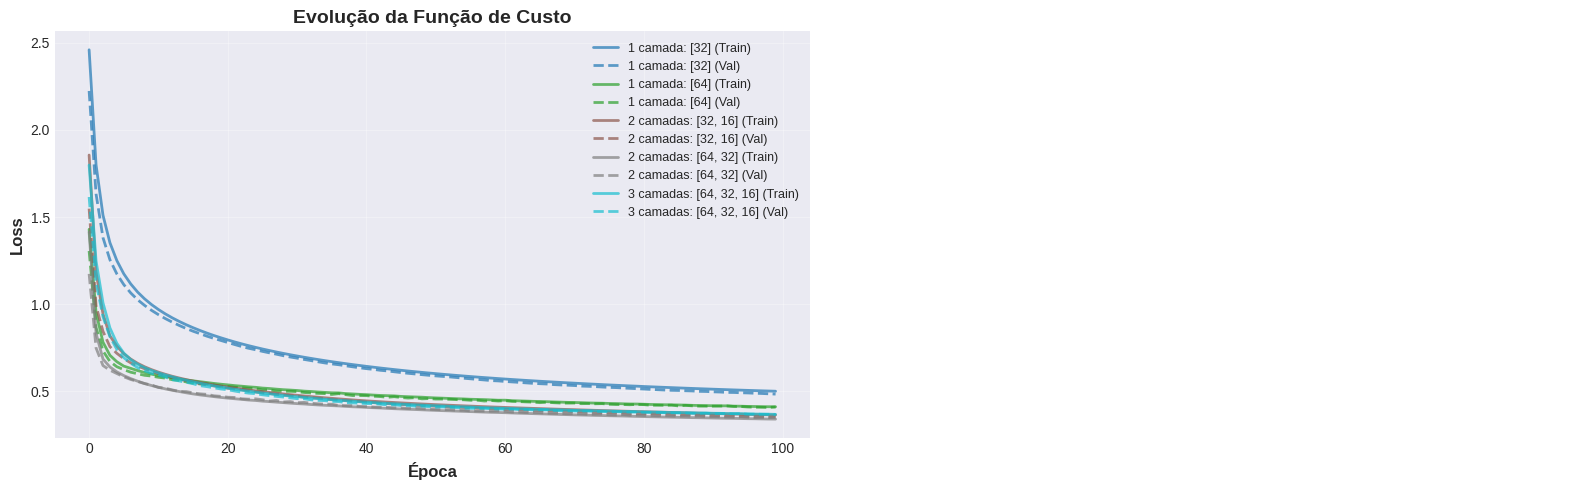


 TABELA DE RESULTADOS - DIFERENTES TOPOLOGIAS
              Topologia MSE Teste MAE Teste R² Score Loss Final (Train) Loss Final (Val)
         1 camada: [32]    0.5248    0.5134   0.5567             0.4994           0.4829
         1 camada: [64]    0.4436    0.4638   0.6253             0.4101           0.4087
    2 camadas: [32, 16]    0.3955    0.4415   0.6659             0.3632           0.3518
    2 camadas: [64, 32]    0.3799    0.4183   0.6791             0.3392           0.3490
3 camadas: [64, 32, 16]    0.3947    0.4271   0.6666             0.3667           0.3653

 Melhor Topologia: 2 camadas: [64, 32]
   R² Score: 0.6791

 Gráfico de predições.


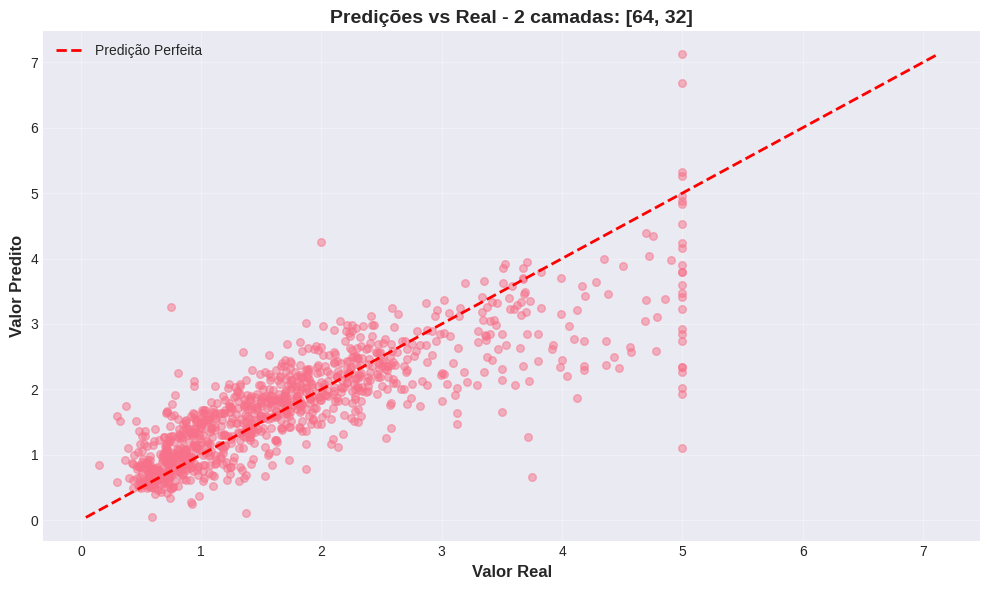


EXPERIMENTO 2: Avaliando o Impacto do Momentum

Objetivo: Avaliar como o momentum afeta a convergência
Topologia fixa: [64, 32]


 ° Treinando com Momentum = 0.0
  Época  20/100 | Train Loss: 0.5020 | Val Loss: 0.5113
  Época  40/100 | Train Loss: 0.4228 | Val Loss: 0.4304
  Época  60/100 | Train Loss: 0.3854 | Val Loss: 0.3897
  Época  80/100 | Train Loss: 0.3646 | Val Loss: 0.3713
  Época 100/100 | Train Loss: 0.3495 | Val Loss: 0.3554

   MSE no Teste: 0.3921
   MAE no Teste: 0.4286
   R² Score: 0.6687

 ° Treinando com Momentum = 0.5
  Época  20/100 | Train Loss: 0.4215 | Val Loss: 0.4191
  Época  40/100 | Train Loss: 0.3661 | Val Loss: 0.3662
  Época  60/100 | Train Loss: 0.3657 | Val Loss: 0.3488
  Época  80/100 | Train Loss: 0.3294 | Val Loss: 0.3315
  Época 100/100 | Train Loss: 0.3181 | Val Loss: 0.3154

   MSE no Teste: 0.3432
   MAE no Teste: 0.4016
   R² Score: 0.7101

 ° Treinando com Momentum = 0.9
  Época  20/100 | Train Loss: 0.3292 | Val Loss: 0.3203
  Época  40/100 |

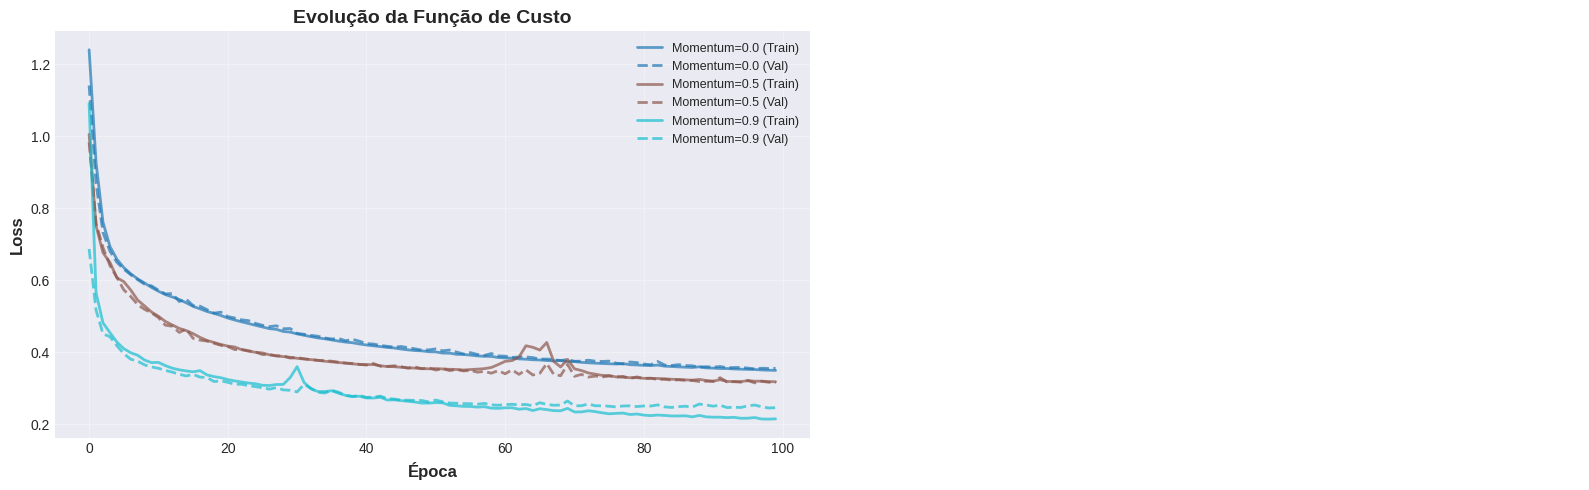


 TABELA DE RESULTADOS - IMPACTO DO MOMENTUM
Configuração MSE Teste MAE Teste R² Score
Momentum=0.0    0.3921    0.4286   0.6687
Momentum=0.5    0.3432    0.4016   0.7101
Momentum=0.9    0.3086    0.3643   0.7393

EXPERIMENTO 3: Avaliando o Impacto da Regularização L2

Objetivo: Avaliar como a regularização L2 previne overfitting
Topologia fixa: [64, 32]


 ° Treinando com L2 Lambda = 0.0
  Época  20/100 | Train Loss: 0.5352 | Val Loss: 0.5317
  Época  40/100 | Train Loss: 0.4319 | Val Loss: 0.4310
  Época  60/100 | Train Loss: 0.3807 | Val Loss: 0.3786
  Época  80/100 | Train Loss: 0.3536 | Val Loss: 0.3475
  Época 100/100 | Train Loss: 0.3377 | Val Loss: 0.3337

 MSE no Teste: 0.3742
MAE no Teste: 0.4216
R² Score: 0.6839

 ° Treinando com L2 Lambda = 0.001
  Época  20/100 | Train Loss: 0.5035 | Val Loss: 0.5046
  Época  40/100 | Train Loss: 0.4208 | Val Loss: 0.4200
  Época  60/100 | Train Loss: 0.3882 | Val Loss: 0.3856
  Época  80/100 | Train Loss: 0.3686 | Val Loss: 0.3659
  Época

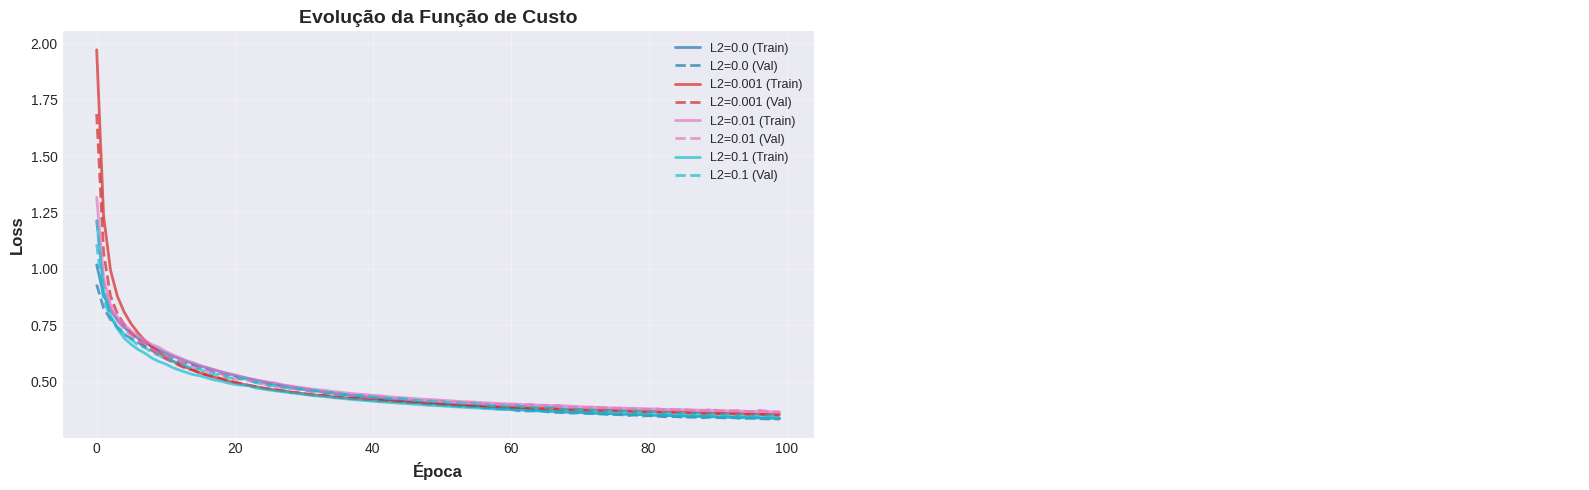


TABELA DE RESULTADOS - IMPACTO DA REGULARIZAÇÃO L2
Configuração MSE Teste MAE Teste R² Score
      L2=0.0    0.3742    0.4216   0.6839
    L2=0.001    0.3892    0.4312   0.6713
     L2=0.01    0.3846    0.4300   0.6751
      L2=0.1    0.3652    0.4141   0.6915

RELATÓRIO FINAL - REGRESSÃO

RESUMO DOS EXPERIMENTOS:

 1.TOPOLOGIAS TESTADAS:
   1. 1 camada: [32]: R² = 0.5567, MSE = 0.5248
   2. 1 camada: [64]: R² = 0.6253, MSE = 0.4436
   3. 2 camadas: [32, 16]: R² = 0.6659, MSE = 0.3955
   4. 2 camadas: [64, 32]: R² = 0.6791, MSE = 0.3799
   5. 3 camadas: [64, 32, 16]: R² = 0.6666, MSE = 0.3947

 2.IMPACTO DO MOMENTUM:
   • Momentum=0.0: R² = 0.6687, MSE = 0.3921
   • Momentum=0.5: R² = 0.7101, MSE = 0.3432
   • Momentum=0.9: R² = 0.7393, MSE = 0.3086

 3.IMPACTO DA REGULARIZAÇÃO L2:
   • L2=0.0: R² = 0.6839, MSE = 0.3742
   • L2=0.001: R² = 0.6713, MSE = 0.3892
   • L2=0.01: R² = 0.6751, MSE = 0.3846
   • L2=0.1: R² = 0.6915, MSE = 0.3652

 MELHOR MODELO GERAL

Configuração: Momentum=0

In [211]:
# Experimentos de regressão
reg_results = run_regression_experiments()